## AVistra Corp: Asignment for Forecasting Electricity Output from Wind Farm Speed Data

This notebook is used to addrrres a given assignment provided by  Vistra Corp Energy Company by August 22, 2023 for forecasting electric output. It focuses on forecasting electricity output using historical wind farm speed data.


### Overview

The work addressed data preprocessing, cleaning, EDA, and features slelection to make the data set suitable for model development. Further, the hyperparameters tuning were performed to obtain the best parameters for forecasting the expected electricity output. The model explainabilities of the specific and global parameters were covered once the best models performance evaluated and selected. Last, summary and further thought were included to the end.



### Problem Statement


The objective to understand and to predict the electricity output from a wind farm using wind speed data from various locations. The historical (as train data set) was used to develp different model to generat prediction with predict(unseed) data set.


## Executive Summary

The initial data analysis involved assessing data types and addressing duplicate, missing, and outlier values. Feature selection was conducted alongside exploratory data analysis (EDA) to visually evaluate the significance of features in relation to the target variable (CF).

To manage potential data leakage, recursive feature selection techniques were employed. Upon preparing the data set for modeling, a grid search was employed to identify the optimal hyperparameters for fine-tuning and identifying the best-performing models.

The AI SHAP technique was then leveraged to investigate the impact of each feature on the 'Electric output (CF)' while providing model interpretability. Finally, the achieved outcomes, along with practical recommendations, are presented to conclude the analysis and address the primary objectives.



### Outlines of the Contents

These are the contents of the Notebook:

- [1 Load the Dataset](#1-Load-the-Data)
 * [1.1 Importing Libraries](#1.1-Import-the-libraries)
 * [1.2 Data Reading](#1.2-Data-Reading)
- [2 Data Analysis and Preprocessing](#2Data-Analysis-and-Preprocessing)
 * [2.1 Handling Missing Data](#2.1-Handling-Missing-Data)
 * [2.2 Anomaly Detection and Feature Selection](#2.2-Anomaly-Detection-and-Feature-Selection)
- [3 Models Exploration and Building](#3-Models-Exploration-and-Building)
    * [3.1 Split the Data Set ](#3.1-Split-the-Data-Set)
    * [3.2 Establish Baseline Model](#3.2-Establish-Baseline-Model)
    * [3.3 Setting up Decision Tree](#3.3-Setting-up-Decision-Tree)
    * [3.4 Setting up XGBoost Regressor](#3.4-Setting-up-XGBoost-Regressor)
    * [3.5 Model Explainability using SHAP](#3.5-Model-Explainability-using-SHAP)
    * [3.6 Deep Learning Model](#3.6-Deep-Learning-Model)
- [4 Comparison of Baseline Model vs Improved Models](#4-Comparison-of-Baseline-Model-vs-Improved-Models)
- [5 Forecast Electric Output(CF_pred) using unseen Data Set](#5-Forecast-Electric-Output(CF_pred)-using-unseen-Data-Set)
- [6 Summary](#6-Summary)
- [7 Further Improvement Thoughts](#7-Further-Improvement-Thoughts)

## 1 Load the Dataset
### 1.1 Importing Libraries

In [1]:
# Data manipulation and analysis libraries
import pandas as pd
import numpy as np

# Date and time handling
import datetime

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data preprocessing libraries
from sklearn.preprocessing import MinMaxScaler

# FastML library for utility functions and feature selection
# !pip install fast_ml --upgrade
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

# Feature engineering libraries
# Import selected classes from feature-engine
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropCorrelatedFeatures
)

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# SHAP library for explaining machine learning models
import shap

### 1.2 Data Reading 
Load the data set into a pandas DataFrame.

In [2]:
# Read a predict data that can be used as out of sample to generate the prediction
second_sheet_name = 'Predict'
# the df_predict DataFrame is the out of sample data to generate the test output
df_predict = pd.read_excel("../VISTA_Asignment/AVistra/Wind_data.xlsx", sheet_name=second_sheet_name)

In [3]:
# Read the train data sheet by name
sheet_name = 'Train'
df = pd.read_excel("../VISTA_Asignment/AVistra/Wind_data.xlsx", sheet_name=sheet_name)

In [4]:
# Unseen data set for predict with the best model value
df_predict.shape

(93, 114)

In [5]:
# Train data set for model development
df.shape

(3635, 114)

## 2 Data Analysis and Preprocessing
### 2.1 Handling Missing Data
Deal with missing values in the data set. Options include removing rows/columns with missing values or imputing them.

In [6]:
def excluding_duplicate_features_and_get_distinic_record_id(df):
 
    """
    Remove duplicate columns (features) from a DataFrame and creat records Identifiers.

    param:
         df : The DataFrame containing the train or unseen data set for model development and prediction.

    Returns:
           df: DataFrame with duplicate columns removed and RID column from Datetime feature.
    """
    # Initialize a dictionary to store unique columns
    unique_columns = {}

    # Iterate through columns
    for col in df.columns:
        column_values = tuple(df[col])
        if column_values not in unique_columns.values():
            unique_columns[col] = column_values

    # Create a DataFrame from the unique columns
    unique_df = pd.DataFrame(unique_columns)
    
    # Record Identifier is unique ID for the data set (i.e 'DATETIME' feature)
    column_names = {'DATETIME': 'RID'}
    unique_df.rename(columns=column_names, inplace=True)
   

    # Remove any duplicated records based on the RID
    df_RID=unique_df.drop_duplicates(subset =["RID"], keep = "first").reset_index(drop = True)
       
    return df_RID # There was one duplicated feature and it can be drop the repeated one with this fuction.

In [7]:
# Apply the function for train data cleaning
df = excluding_duplicate_features_and_get_distinic_record_id(df)
df.shape # The shape number indicates there was one duplicated feature and it already removed from the data set. 

(3635, 113)

In [8]:
df.head()

,RID,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
0,2019-08-07 00:00:00,0.652524,10.35,8.99,4.57,9.69,8.90,2.90,5.74,1.16,...,11.12,6.79,9.31,11.63,10.72,10.55,11.41,10.77,10.17,9.24
1,2019-08-07 01:00:00,0.605852,9.70,8.28,5.78,9.10,7.98,2.23,3.46,0.97,...,10.47,6.40,9.50,11.10,11.02,9.91,11.16,10.98,10.16,9.09
2,2019-08-07 02:00:00,0.564094,9.04,7.39,6.21,8.98,7.78,1.98,2.62,0.92,...,10.10,6.23,9.46,10.74,11.19,9.52,11.00,11.10,10.04,9.04
3,2019-08-07 03:00:00,0.532721,8.78,7.49,6.43,8.84,7.82,1.33,2.43,0.68,...,9.67,6.01,9.45,10.65,11.27,9.11,10.93,11.18,10.20,8.89
4,2019-08-07 04:00:00,0.495608,8.23,6.88,6.81,8.52,6.65,1.64,2.45,0.59,...,9.24,5.83,9.30,9.78,10.85,8.64,10.69,10.83,9.88,8.67


#### Group Missed Value if it exist for visualization

In [9]:
# Evaluting missed value in the data set to creat graph if it exist
def missed_feature_volumn_n(df):
    missed = []
    for col in (list(df.columns)):
        value1 = df[col].isna().sum()*100/df.shape[0]
        missed.append(value1)
    df_missed = pd.DataFrame(data = missed, index = df.columns)
    df_missed.columns = ['missed_perc']
#     print(df_missed.head())
    df_missed['group'] = df_missed['missed_perc'].apply(lambda x:'100-80'if (x<=100)&(x>=80) else
                        '60-80'if (x<80) & (x>=60) else '30-60'if(x<60)&(x>=30) else '1-30' if (x<30)&(x>=1)
                                                        else '0')
    df_missed.reset_index(inplace=True)
    #print(df_missed)
    df_missed.rename(columns = {'index': 'feature'}, inplace = True)
    df_missed_group = df_missed.groupby('group').agg({'feature': 'count'}).reset_index()
    return df_missed, df_missed_group

In [10]:
# Read the missed value if it exist in the train data set
df_missed, df_missed_group = missed_feature_volumn_n(df)

In [11]:
df_missed.shape

(113, 3)

In [12]:
# This indicates there is not any missed value in the data set
df_missed.head()

,feature,missed_perc,group
0,RID,0.0,0
1,CF,0.0,0
2,WS_1133733,0.0,0
3,WS_1156770,0.0,0
4,WS_1156968,0.0,0


In [13]:
# group of the missed value classes it exist
df_missed_group

,group,feature
0,0,113


In [14]:
df.shape

(3635, 113)

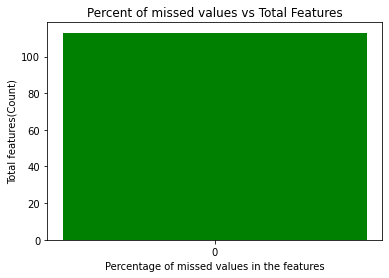

In [15]:
# The graph indicate the train dta doesn't have any missed value
colors = ['green', 'red', 'blue', 'green', 'purple']  # Define colors for each bar'grbkymc'
plt.bar(df_missed_group['group'], df_missed_group['feature'], color= colors)
#Add title and axis name
plt.title('Percent of missed values vs Total Features')
plt.xlabel('Percentage of missed values in the features')
plt.ylabel('Total features(Count)')
plt.show;

In [16]:
# predict (unseen) data set without targate column
df_predict1=df_predict.drop('CF', axis=1)

In [17]:
# Read the missed value if it exist in the predict data set
df_missed_unseen_data, df_missed_group_unseen_data = missed_feature_volumn_n(df_predict1)

In [18]:
df_missed_unseen_data.head()

,feature,missed_perc,group
0,DATETIME,0.0,0
1,WS_1133733,0.0,0
2,WS_1156770,0.0,0
3,WS_1156968,0.0,0
4,WS_1182195,0.0,0


In [19]:
#  Give unseen data set also doesn't has missed value 
df_missed_group_unseen_data

,group,feature
0,0,113


Note: 
- __Both the train and unseen (test) data set don't have any missed values.__

### 2.2 Anomaly Detection and Feature Selection
Anomaly detector of the data including constant, quasi-constant and outlier detection. In addition, correlation-based and Recursive Feature Selection (RFS) were applied to have valuable size features for better model development. 
With default XGBRegressor model applied to perform RFS to removes the least important features and those features created data leakage with the 'CF target. The correlation base feature selection was performed the written functions to extract non correlated features. These help to keep the most important features size out of all the given 114 features for model development as well as generating the prediction with the selected best performing model.

#### Constant and Quasi-Constant Reduction

In [20]:
# Constant features are those that contain only one single value for all the observations.
# Quasi-constant features are a significant portion of the observations that shows the same value except very few observations
# To get all the constant features as a list

def reduce_constant_features(df):
    # Looking 100% constant features to drop it from the datafram
    constant_features = get_constant_features(df)
    
    #To drop these features from the dataset
    constant_features_list = constant_features.query("Desc=='Constant'")['Var'].to_list()
    constant_features_list = set(constant_features_list)
    df.drop(columns=constant_features_list, inplace =True)
    
    return df

In [21]:
df = reduce_constant_features(df)
df.shape # there is not 100% constant similar observation contain features.

(3635, 113)

In [22]:
def reduce_quasi_constant_features(df, threshold):
    
    # Remove features which have 95% similar observation acrose the features
    constant_features = get_constant_features(df, threshold=threshold, dropna=False)
    quasi_constant_features_list = constant_features.query("Desc=='Quasi Constant'")['Var'].to_list()
    
    # To remove frequently repeated features prior to drop it
    quasi_constant_features_list = set(quasi_constant_features_list)
    
    # To drop these quasi constant features from dataset
    df.drop(columns =quasi_constant_features_list, inplace = True)
    
    return df

In [23]:
# Detecting the constant observation in the features of the data set at given threshold 
df = reduce_quasi_constant_features(df, 0.95)

In [24]:
# There is no any Quasi-constant features with a variance of 5% since the shape is the same as the original
df.shape

(3635, 113)

In [25]:
def anomaly_detector(df,feature):
   
    """
    This function identifies outliers and missing values for a given features

    :param df: billing data dataframe
    :param feature: feature to look for outliers and missing values

    :return: Provides number of outliers and missing value of the features
    """
   
    NN = df[feature].shape[0]
   
    # Total number of outliers
    print('\nOutlier caps for <<<< {} >>>>:'.format(feature))

     # Number of zeros in the data set
    print(' --zero: {:,.0f}({:,.1f}%) values are zero(s) out of {:,}'.format(df[df[feature]==0].shape[0],
                                                                   100*df[df[feature]==0].shape[0]/NN,NN))

    # Number of missed values in the data set
    print(' --Null: {:,.0f}({:,.1f}%) values are NaN(s) out of {:,}'.format(df[feature].isnull().sum(),
                                                                  100*df[feature].isnull().sum()/NN,NN))


    if df[feature].dtype == float or df[feature].dtype == int:
        
        # Negative values of the data set
        print(' --Negative: {:,.0f}({:,.1f}%) values are zero(s) out of {:,}'.format(df[df[feature]<0].shape[0],
                                                               100*df[df[feature]<0].shape[0]/NN,NN))
        data = df[feature]
        mean = data.mean()
        std =data.std()
       

        z_score = np.abs(data - mean)/std
        
        
        # Three standard deviation (~99.7)
        Lrs = len(z_score[z_score > 3])

        p95 = data.quantile(.95)
        Lenp95 = len(df[feature][df[feature]>p95])

        p99 = data.quantile(.99)
        Lenp99 = len(df[feature][df[feature]>p99])


        print('  --95p is {:,.1f} and {:,}({:,.1f}%) values exceed that'.format(p95, Lenp95, 100*Lenp95/NN))

        print('  --99p is {:,.1f} and {:,}({:,.1f}%) values exceed that'.format(p99, Lenp99, 100*Lenp99/NN))

        print('  --3sd is {:,.1f} and {:,}({:,.1f}%) values exceed that'.format(mean + 3*(std), Lrs,100*Lrs/NN))

In [26]:
# Use the anomal and data distribution detection  apply
def use_anomal_detection(df):
   
    # Drop the RID and target for this analysis
    df_out_RID=df.drop(['RID', 'CF'], axis=1)
    # Creat list of the features to feed the the fuctions
    list_of_features = df_out_RID.columns
    
    for col in list_of_features:
        anomaly_detector(df_out_RID, col)
    return df

In [27]:
# It shows the data quantil value in specific perentages.
df = use_anomal_detection(df) 


Outlier caps for <<<< WS_1133733 >>>>:
 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 9.8 and 180(5.0%) values exceed that
  --99p is 11.9 and 37(1.0%) values exceed that
  --3sd is 12.9 and 13(0.4%) values exceed that

Outlier caps for <<<< WS_1156770 >>>>:
 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 8.6 and 182(5.0%) values exceed that
  --99p is 10.2 and 37(1.0%) values exceed that
  --3sd is 11.1 and 23(0.6%) values exceed that

Outlier caps for <<<< WS_1156968 >>>>:
 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 10.3 and 182(5.0%) values exceed that
  --99p is 12.8 and 36(1.0%) values exceed that
  --3sd is 13.3 and 25(0.7%) values exceed th

 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 11.8 and 182(5.0%) values exceed that
  --99p is 14.5 and 37(1.0%) values exceed that
  --3sd is 15.4 and 19(0.5%) values exceed that

Outlier caps for <<<< WS_73451 >>>>:
 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 9.7 and 181(5.0%) values exceed that
  --99p is 12.3 and 37(1.0%) values exceed that
  --3sd is 13.1 and 22(0.6%) values exceed that

Outlier caps for <<<< WS_73494 >>>>:
 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 12.7 and 181(5.0%) values exceed that
  --99p is 15.0 and 37(1.0%) values exceed that
  --3sd is 16.6 and 12(0.3%) values exceed that

Outlier caps for <<<< WS_73822 >>>>:
 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 -

 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 12.2 and 182(5.0%) values exceed that
  --99p is 14.4 and 37(1.0%) values exceed that
  --3sd is 15.9 and 20(0.6%) values exceed that

Outlier caps for <<<< WS_920775 >>>>:
 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 11.6 and 182(5.0%) values exceed that
  --99p is 13.8 and 36(1.0%) values exceed that
  --3sd is 15.1 and 15(0.4%) values exceed that

Outlier caps for <<<< WS_921049 >>>>:
 --zero: 0(0.0%) values are zero(s) out of 3,635
 --Null: 0(0.0%) values are NaN(s) out of 3,635
 --Negative: 0(0.0%) values are zero(s) out of 3,635
  --95p is 10.6 and 182(5.0%) values exceed that
  --99p is 13.6 and 37(1.0%) values exceed that
  --3sd is 13.8 and 35(1.0%) values exceed that


Note: 
 
- Let takes __Outlier caps for <<<< WS_921049 >>>>__ as an example to describe results shown:
The initial three bullet points indicate that this feature without zero values, missing values, and negative values.
The same feature exhibits 95th and 99th percentile values of 10.6 and 13.6, respectively. Among the values, 182 (5%) surpass the 96th percentile, while 37 (1.0%) exceed the 99th percentile. The calculated mean plus three times the standard deviation (mean + 3SD) amounts to 13.6. There are 35 values, representing 1.0% of the data set, that surpass the threshold of 13.8. Furthermore, 37 values fall beyond the 99th percentile, and similarly, 35 values lie outside the range of three standard deviations (SD). These observations suggest the possible existence of outliers within the data set. I would have asked the _stakeholders or subject matter experts (SMEs)_ regarding these values, which may be concider as outliers.  **For the time being I willl keep them as it is.**

In [28]:
# Separating binary and continuous features
def separate_binary_nonbinary_var(df_):
    
    #drop the RID and target for this analysis
    df=df_.drop(['RID', 'CF'], axis=1)
    
    """
    This function separates continuous and binary variables from the input dataframe
    parameters

    :param df: input train dataframe with continuous and binary variables

    :return
    provides two separate datafrrames for continuous and binary variables

    """
    var_cat = []
    var_con = []
    for col in list(df.columns[1:]):
        if df[col].nunique()<=3:
            var_cat.append(col)
        else:
            var_con.append(col)
    return var_cat, var_con


#Eliminate highly correlated features
def get_noncorrelated_features(corr_threshold, ColNames, df):

    """
    This function is used to eliminate highly correlated features
    parameters

    :param corr_threshold: minimum threshold value for feature elimination
    :param ColNames: list of columns of the input dataframe to use for model building
    :param df: input dataframe



    :return
            provides list of non-correlated features
    """

    # Set up the transformer for Dropping redundant features
    tr0 = DropDuplicateFeatures()

    # fit the transformer and get non-redundant features
    df1 = tr0.fit_transform(df[ColNames])

    # Separating cat and cont features
    catx, contx = separate_binary_nonbinary_var(df1)

    # Isolating continuous/categorical features
    df2 = df1[contx]
    df4 = df1[catx]


    # Set the transformer to drop highly correlated features
    tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=corr_threshold)

    # fit the transformer and get non-correlated features
    df3 = tr.fit_transform(df2)

    # Get non-redundant and uncorrelated features
    df5 = pd.concat([df3, df4], axis=1).reset_index(drop=True)
    
    # Insert the new column at the first position
    df5.insert(0, 'RID', df['RID'])
    
    # Insert the new column at the first position
    df5.insert(1, 'CF', df['CF'])


    return tr0.duplicated_feature_sets_, tr.correlated_feature_sets_, df5

In [29]:
var_cat, var_con = separate_binary_nonbinary_var(df)
print('Total Number of Categorical Features:', len(var_cat))
print('Total Number of Continuous Features:', len(var_con))

Total Number of Categorical Features: 0
Total Number of Continuous Features: 110


Note:
- This suggests that the training dataset does not contain categorical features.

In [30]:
# Detect and drop highly correlated featres (threshold =0.95) from the train data set.
duplicated_feature_sets, correlated_feature_sets, df1= \
                            get_noncorrelated_features(0.95, df.columns, df=df)

In [31]:
print('Shape of Data set before correlation:', df.shape)

print('Shape of Data set after correlation:', df1.shape)

Shape of Data set before correlation: (3635, 113)
Shape of Data set after correlation: (3635, 38)


In [32]:
# There is no duplicated features in the train data set
duplicated_feature_sets

[]

In [33]:
# Sample correlated features take as example
df_example=df[['WS_1133733','WS_1156770', 'WS_1369320', 'WS_1960535','WS_2460378']].corr()

In [34]:
df_example

,WS_1133733,WS_1156770,WS_1369320,WS_1960535,WS_2460378
WS_1133733,1.000000,0.985250,0.979153,0.992689,0.990623
WS_1156770,0.985250,1.000000,0.938923,0.989182,0.990936
WS_1369320,0.979153,0.938923,1.000000,0.957442,0.955429
WS_1960535,0.992689,0.989182,0.957442,1.000000,0.989490
WS_2460378,0.990623,0.990936,0.955429,0.989490,1.000000


In [35]:
# Non-correlated (correlation below 95% taken) to be moderate for features reductions.
df1.head()

,RID,CF,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1369320,...,WS_2118117,WS_2385763,WS_2455069,WS_2467589,WS_2503597,WS_676403,WS_74180,WS_77720,WS_839753,WS_914573
0,2019-08-07 00:00:00,0.652524,8.99,4.57,9.69,8.90,2.90,5.74,1.16,11.14,...,5.75,10.45,8.99,5.84,11.75,6.73,8.32,7.07,9.31,11.41
1,2019-08-07 01:00:00,0.605852,8.28,5.78,9.10,7.98,2.23,3.46,0.97,10.49,...,5.63,10.72,8.92,5.35,11.67,5.58,7.65,6.65,9.50,11.16
2,2019-08-07 02:00:00,0.564094,7.39,6.21,8.98,7.78,1.98,2.62,0.92,10.12,...,5.62,10.22,9.01,5.09,11.37,5.26,7.20,6.43,9.46,11.00
3,2019-08-07 03:00:00,0.532721,7.49,6.43,8.84,7.82,1.33,2.43,0.68,9.65,...,5.66,10.49,9.35,4.85,11.25,4.61,6.84,6.22,9.45,10.93
4,2019-08-07 04:00:00,0.495608,6.88,6.81,8.52,6.65,1.64,2.45,0.59,9.21,...,5.60,10.62,9.18,4.48,10.77,3.97,6.38,6.04,9.30,10.69


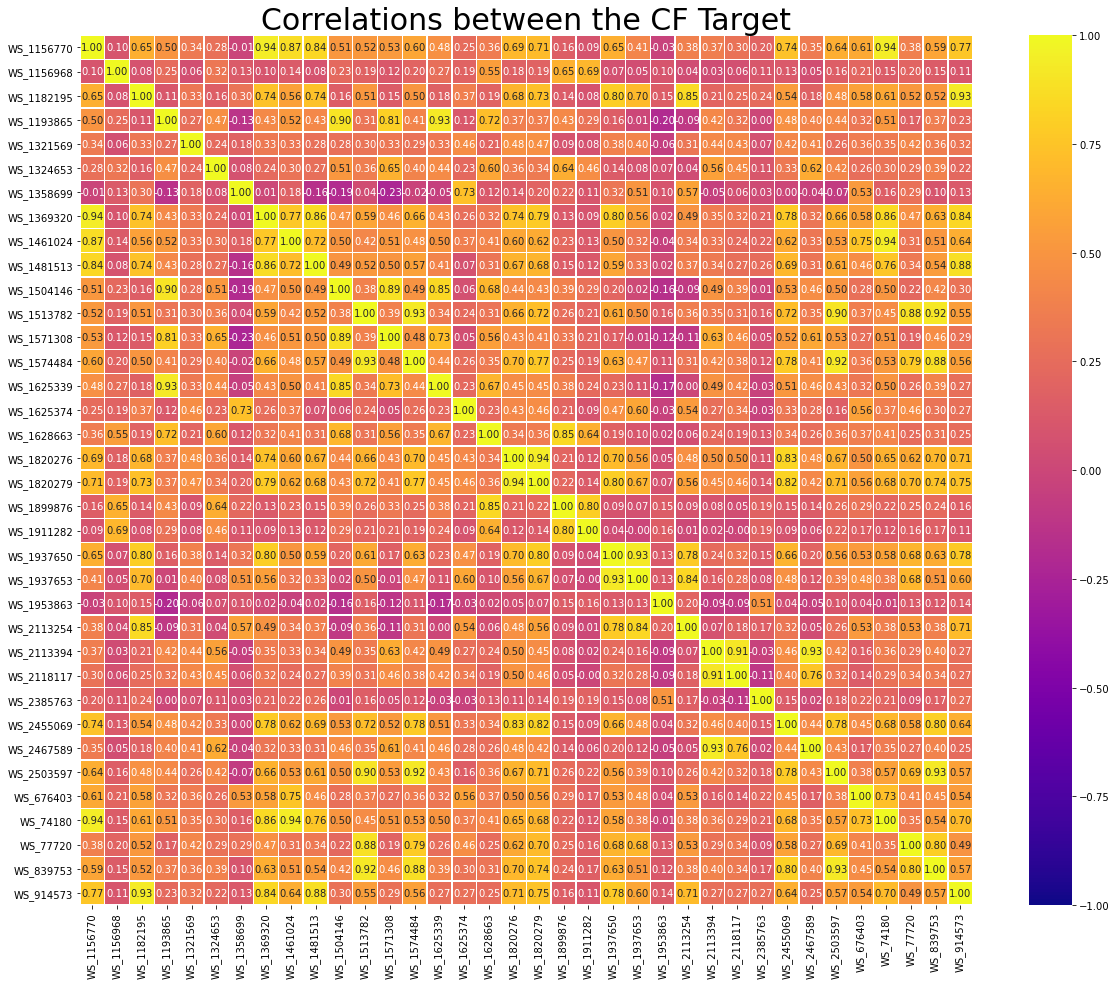

In [36]:
df3=df1.drop(['RID', 'CF'],axis=1).corr()
plt.figure(figsize=(20,16))
sns.heatmap(df3,annot=True, fmt='.2f',linewidths=.5, vmin=-1, vmax=1,cmap='plasma')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.axis('tight')
plt.title('Correlations between the CF Target',fontsize=30);

Note:
- This is to visualize the level of correlation between the features. There is no strong correlation observed in the map.

In [37]:
# Now let's see the correlations of the predictors with target variable.
df1.corr()['CF'].sort_values(ascending=False)

CF            1.000000
WS_2503597    0.848757
WS_1574484    0.792030
WS_839753     0.777407
WS_2455069    0.761114
WS_1513782    0.754954
WS_1369320    0.720789
WS_1156770    0.710433
WS_1481513    0.696518
WS_1571308    0.663142
WS_1504146    0.661383
WS_74180      0.650509
WS_1820279    0.624127
WS_1461024    0.601257
WS_1193865    0.594679
WS_1820276    0.590881
WS_914573     0.579387
WS_1625339    0.558840
WS_77720      0.521815
WS_1937650    0.495025
WS_1628663    0.458675
WS_1182195    0.428863
WS_2467589    0.424478
WS_2113394    0.420708
WS_1324653    0.417947
WS_676403     0.367448
WS_2118117    0.299778
WS_1937653    0.267246
WS_1899876    0.266699
WS_1321569    0.227482
WS_1911282    0.205853
WS_1156968    0.170152
WS_2385763    0.167350
WS_2113254    0.151538
WS_1625374    0.068567
WS_1953863    0.055221
WS_1358699   -0.169850
Name: CF, dtype: float64

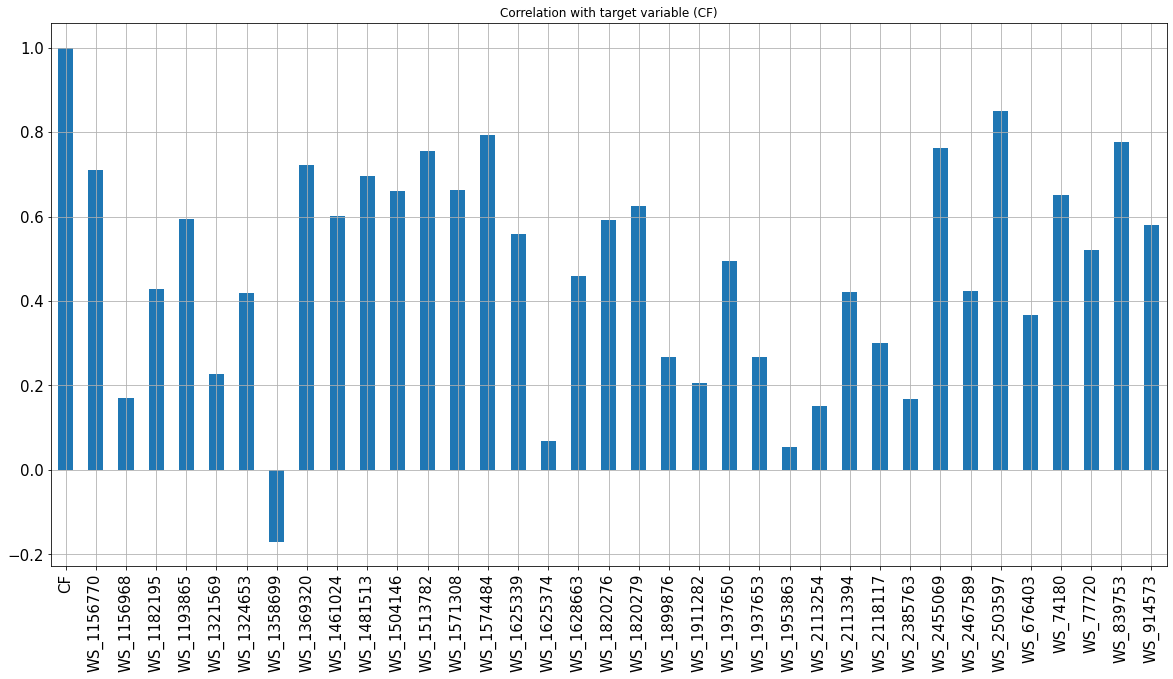

In [38]:
# This is further to show how the selected feature correlate with the CF taget
df1.corrwith(df1['CF']).plot.bar(figsize=(20,10),title="Correlation with target variable (CF)", 
                                                        fontsize = 15, rot = 90, grid = True);

One can clearily see from the above figure all have positive correlation with the target variables(CF) except WS_1358699.   WS_2503597 has with highest correlation about close to 0.85 with the target variable.

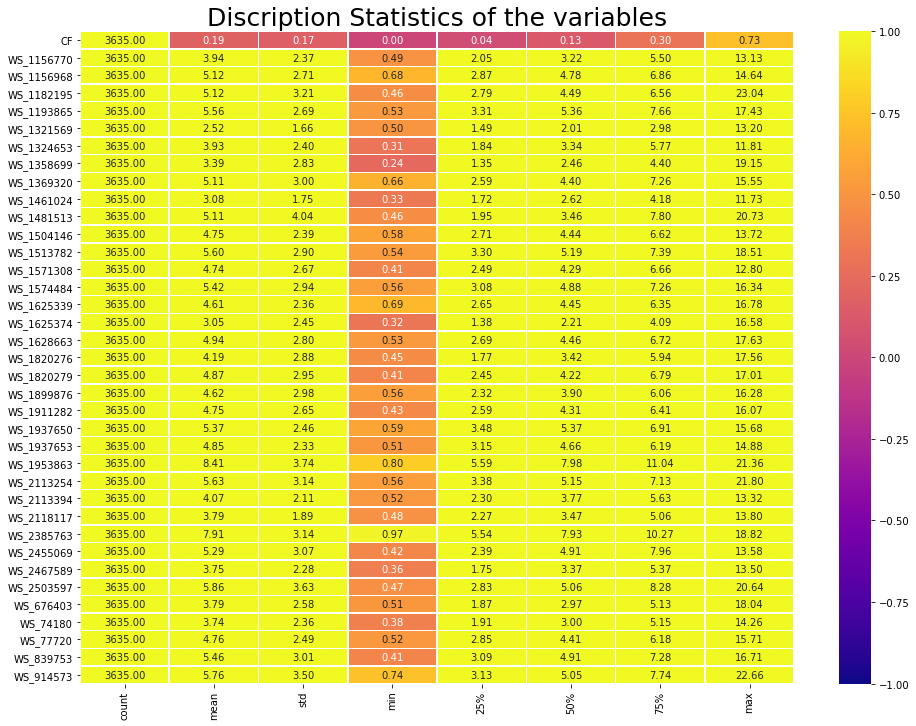

In [39]:
# This is to visualize the train data set description
plt.figure(figsize=(16,12))
sns.heatmap(df1.describe().T,annot=True, fmt='.2f',linewidths=.5, vmin=-1, vmax=1,cmap='plasma')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.axis('tight')
plt.title('Discription Statistics of the variables',fontsize=25);

###  Recursive Feature Selection 
- Default XGBRegressor model used to identifies the most potential features that cause target leakages. Successive default XGB model was run for the experimenting. I found the features  with columns names =['WS_2503597', 'WS_1574484', 'WS_839753', 'WS_1513782', 'WS_2455069', 'WS_1156770'] dominate the others with features importance values above 77%. Decide to keep these features out of the selected train data set ahead of model building.

In [40]:
df1.shape

(3635, 38)

In [41]:
# Drop features that cause target leakage to maintain predictability capacity of the others
df1 =df1.drop(columns=['WS_2503597', 'WS_1574484', 'WS_839753', 'WS_1513782', 'WS_2455069', 'WS_1156770'], axis =1)
df1.shape

(3635, 32)

## 3 Models Exploration and Building

To address the prediction for this asignment, the following models were utilized for predicting the target electricity output (CF) from wind farm speed of different locations:

* Decision Tree <br>
* XGBoost <br>
* Deep learning using TensorFlow. <br>

After building the models, further, look at the importance of the features of each model. Evaluation of the performance of the models, their comparisons among themselves as well as forecast electric output using unseen data set.

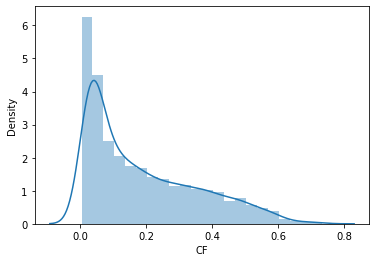

In [42]:
sns.distplot(df1['CF']);

Note:
- The the electric output distribution is highly skewed to right. Some times it would be a good idea to remove those highly skewed data in order to improve model performance with SME recommendation or make tranformation. 

In [43]:
# Distribution of the train data set with electric output
df1['CF'].describe()

count    3635.000000
mean        0.186114
std         0.165140
min         0.003551
25%         0.043264
50%         0.130778
75%         0.299374
max         0.733128
Name: CF, dtype: float64

### 3.1 Split the Data Set 
Splitting the data set into training and test data sets

In [44]:
df_model= df1.copy()

In [45]:
def datetime_train_test_split(df):
    """
    Split a DataFrame into train and test sets based on a datetime column.

    param:
         data: The DataFrame containing the data.
         datetime_col: Name of the datetime column.
         target_col ('CF'): Name of the target variable column(electric output.
         test_size : Proportion of data to be used for the test set.
                                

    Returns:
         X_train: Features in dataframe for the training set.
         X_test: Features in dataframe for the test set.
         y_train: Target variable in pandas series for the training set.
         y_test: Target variable in pandas series for the test set.
    """
     
    # Convert Record Identifier 'RID' column to datetime type
    df['RID'] = pd.to_datetime(df['RID'])

    # Sort the DataFrame by 'timestamp'
    df.sort_values(by='RID', inplace=True)

    # Determine the split point at 80/20 for train/test data set of the train data
    split_date = '2019-12-07 23:00:00'

    # Split data into train and test sets based on the split point
    train_df = df[df['RID'] < split_date]
    test_df = df[df['RID'] >= split_date]

    # Drop the 'RID' and target (electric output) columns columns from train and test sets
    X_train = train_df.drop(['CF', 'RID'], axis=1)
    y_train = train_df['CF']

    X_test = test_df.drop(['CF', 'RID'], axis=1)
    y_test = test_df['CF']
    
    return train_df, test_df, X_train, y_train, X_test, y_test 

In [46]:
# Split the train data set for model development
train, test, X_train, y_train, X_test, y_test = datetime_train_test_split(df1)

In [47]:
# Split data set into train test with target (CF electric output) and independent features (farm winds speed)
train.shape, test.shape,  X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((2908, 32), (727, 32), (2908, 30), (2908,), (727, 30), (727,))

In [48]:
# To check the split work as sorted use tail for the train data set and head for the test data set
X_train.tail()

,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1369320,WS_1461024,WS_1481513,WS_1504146,...,WS_1953863,WS_2113254,WS_2113394,WS_2118117,WS_2385763,WS_2467589,WS_676403,WS_74180,WS_77720,WS_914573
2903,7.82,9.57,7.93,1.74,7.43,11.29,6.41,4.50,3.19,6.20,...,1.20,12.87,4.00,2.32,2.37,5.14,7.83,4.64,10.50,6.71
2904,7.68,10.13,7.92,1.68,7.64,12.24,6.32,4.49,3.32,6.46,...,1.94,13.49,3.99,2.31,2.44,5.00,8.50,4.53,10.95,7.25
2905,6.78,10.21,8.33,1.75,7.61,12.30,6.58,4.42,3.54,6.46,...,2.42,13.28,3.42,1.64,2.06,4.72,8.51,4.56,11.19,7.33
2906,6.84,10.68,8.48,1.71,7.23,12.35,6.26,4.53,3.95,6.42,...,2.46,13.56,2.74,1.25,1.82,4.33,9.28,3.86,11.40,7.65
2907,6.82,10.56,8.74,1.54,6.95,12.21,5.85,4.27,3.42,6.16,...,3.28,13.30,2.41,1.58,1.98,4.39,9.61,4.01,10.80,7.64


In [49]:
# # This is exactly the coninuity of the tail of the train data set
test.head()

,RID,CF,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1369320,WS_1461024,...,WS_1953863,WS_2113254,WS_2113394,WS_2118117,WS_2385763,WS_2467589,WS_676403,WS_74180,WS_77720,WS_914573
2908,2019-12-07 23:00:00,0.219679,6.49,10.21,8.14,1.37,7.33,12.52,5.81,4.35,...,3.89,13.14,2.56,1.78,2.83,4.17,9.66,3.78,10.83,7.23
2909,2019-12-08 00:00:00,0.200425,6.82,9.58,7.53,1.35,7.79,11.96,6.19,4.26,...,4.43,12.83,1.81,1.51,3.72,3.38,9.71,3.81,11.03,6.83
2910,2019-12-08 01:00:00,0.181658,7.30,9.20,6.69,1.54,7.50,11.85,6.50,4.06,...,4.73,12.52,1.76,1.48,4.32,3.19,10.10,4.26,10.76,6.31
2911,2019-12-08 02:00:00,0.138335,7.42,8.78,7.17,1.90,7.64,11.25,6.65,3.94,...,6.28,12.17,1.90,1.18,4.89,3.06,9.79,4.25,10.58,6.03
2912,2019-12-08 03:00:00,0.103646,7.49,8.67,6.80,1.68,7.07,10.84,7.58,4.14,...,6.68,12.00,1.67,1.23,5.21,2.89,9.78,4.16,10.55,6.32


### 3.2 Establish Baseline Model
##### Train data set basline model

In [50]:
# The baseline predictions are the historical averages of the actual electric output
Baseline = pd.DataFrame({'CF':y_train, 'Baseline':y_train.mean()})
Baseline.head()

,CF,Baseline
0,0.652524,0.192921
1,0.605852,0.192921
2,0.564094,0.192921
3,0.532721,0.192921
4,0.495608,0.192921


In [51]:
# Calculate MAE using scikit-learn
mae = mean_absolute_error (y_train, Baseline['Baseline'])

print(f"Mean Absolute Error_train: {mae}")

Mean Absolute Error_train: 0.143256156221217


##### Test data set basline model

In [52]:
# The baseline y_pred values need to asign by y_train mean of the data set
Baseline_test = pd.DataFrame({'CF':y_test, 'Baseline_test':y_train.mean()}).reset_index(drop=True)
Baseline_test.head()

,CF,Baseline_test
0,0.219679,0.192921
1,0.200425,0.192921
2,0.181658,0.192921
3,0.138335,0.192921
4,0.103646,0.192921


In [53]:
# Calculate MAE of the test in baseline model
mae_test = mean_absolute_error (y_test, Baseline_test['Baseline_test'])

print(f"Mean Absolute Error of Baseline Test: {mae_test}")

Mean Absolute Error of Baseline Test: 0.12752006663840768


### 3.3 Setting up Decision Tree 
##### Defualt Decision Tree Regressor

In [54]:
# The function to use to carry out the decision tree regressor without hyperparameters without optimization.
def train_evaluate_decision_tree(data, random_state=42):
    
    """
    Train and evaluate a DecisionTreeRegressor model.

    Param:
        data : The DataFrame containing the data.
                                        
        random_state (int, optional): Random state for reproducibility. 

    Returns:
        float: Mean Absolute Error (MAE) of the model.
    """
    # Split the train data for model evaluation
    train, test, X_train, y_train, X_test, y_test = datetime_train_test_split(data)
    
    # Create a DecisionTreeRegressor model
    dt_regressor = DecisionTreeRegressor(random_state=random_state)

    # Train the model
    dt_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    yp_train = dt_regressor.predict(X_train)
    
    # Make predictions on the test set
    yp_test = dt_regressor.predict(X_test)

    # Calculate Mean Absolute Error (MAE) of Decision Tree Regressor
    mae_dtr_train = mean_absolute_error(y_train, yp_train)

    
    # Calculate Mean Absolute Error (MAE) of Decision Tree Regressor
    mae_dtr_test = mean_absolute_error(y_test, yp_test)

    return mae_dtr_train, mae_dtr_test, yp_train, yp_test

#### Model Performance on training data set (MAE)

In [55]:
# Without optimization the Decision Tree Regressor performance
mae_dtr_train, mae_dtr_test, yp_train, yp_test = train_evaluate_decision_tree(df1, random_state=42)

mae_dtr_train, mae_dtr_test

(0.0, 0.07395350143627683)

Note:
- __mae_train__ < __mae_test__ shows the model's predictions are exactly match with the actual target values in the training data set as compared with test data. This may be a sign of overfitting, where the model has learned the noise in the training data.

#### Optimized Decision Tree Regressor Performance

In [56]:
# Grid search to tune hyperparameters for best model performance
def best_optimized_decision_tree(data):
    """
    Train and evaluate a DecisionTreeRegressor model with hyperparameter tuning.

    param:
         data: The DataFrame containing the data.
         
    Returns:
           float: Mean Absolute Error (MAE) of the model.
           dict: Feature importance of the best optimized model.
    """
    
    # Split data into train and test sets
    train, test, X_train, y_train, X_test, y_test = datetime_train_test_split(data)

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'max_depth': [5, 6, 7], 
        'min_samples_split': [6, 8, 10],
        'min_samples_leaf': [6, 8, 10]
    }

    # Create a DecisionTreeRegressor
    dt_regressor_best = DecisionTreeRegressor(random_state=42)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(dt_regressor_best, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set
    yp_train = best_model.predict(X_train)
    
    # Make predictions on the test set
    yp_test = best_model.predict(X_test)
    
    # Calculate Mean Absolute Error (MAE) of the best Decision Tree Regressor
    mae_best_train = mean_absolute_error(y_train, yp_train)

    # Calculate Mean Absolute Error (MAE) of the best Decision Tree Regressor
    mae_best_test = mean_absolute_error(y_test, yp_test)
    
    # Calculate feature importance of the best model
    feature_importance = None
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = dict(zip(train.drop(columns=['RID', 'CF'], axis =1).columns, best_model.feature_importances_))


    return mae_best_train, mae_best_test, feature_importance, best_params

In [57]:
# Best performing model MAE value of Decision Tree Regressor(DTR)
mae_best_train, mae_best_test, feature_importance, best_params=best_optimized_decision_tree(df1)
mae_best_train, mae_best_test

(0.04873813717356115, 0.0711364461660078)

Note:
- A slightly higher mae_test compared to mae_train is common, as the model is evaluated on test data. The test performance should still be reasonably close to the training performance, which indicates that the model is not overfitted as seen in the default model performance.

In [58]:
# Optimized hyperparameters for Decision Tree Regressor
best_params

{'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 6}

In [59]:
# Opemized model of Decision Tree Regressor
best_model_DTR = DecisionTreeRegressor(max_depth=5,min_samples_leaf=8,min_samples_split=6, random_state=42)

In [60]:
best_model_DTR.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, min_samples_split=6,
                      random_state=42)

####  Model Performance on training data set (MAE)

In [61]:
dtr_yp_train = best_model_DTR.predict(X_train)  
mae_best_train = mean_absolute_error(y_train, dtr_yp_train)

In [62]:
res_DTR = pd.DataFrame({'CF':y_train, 'Predicted Values_DTR':pd.Series(dtr_yp_train)})
res_DTR.head()

,CF,Predicted Values_DTR
0,0.652524,0.571221
1,0.605852,0.571221
2,0.564094,0.460165
3,0.532721,0.460165
4,0.495608,0.460165


####  Model Performance on test data set (MAE)

In [63]:
dtr_yp_test = best_model_DTR.predict(X_test)  
mae_best_test = mean_absolute_error(y_test, dtr_yp_test)

In [64]:
res_DTR = pd.DataFrame({'CF':y_test, 'Predicted Values_DTR_tes':dtr_yp_test}).reset_index(drop=True)
res_DTR.head()

,CF,Predicted Values_DTR_tes
0,0.219679,0.252048
1,0.200425,0.252048
2,0.181658,0.252048
3,0.138335,0.123985
4,0.103646,0.123985


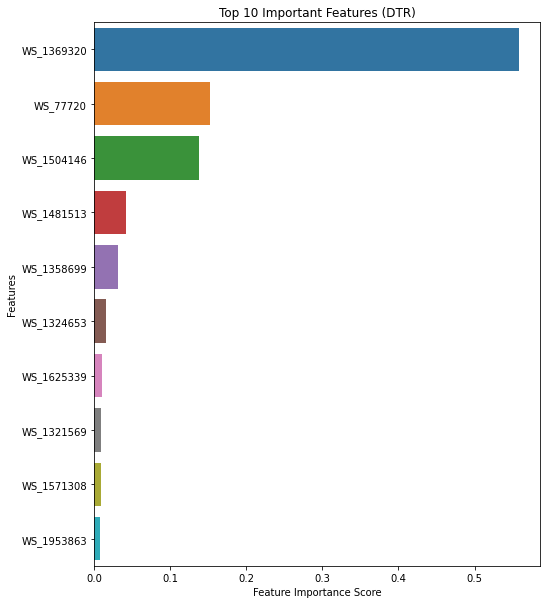

In [65]:
# Feature importance graph
colss= X_train.columns
colx= [colss[x] for x in range(len(colss))]
feature_imp = pd.Series(best_model_DTR.feature_importances_,index=colx).sort_values(ascending=False)

# Get the top 10 features and their importance scores
top_features = feature_imp.head(10)

# Create a bar plot of the top 10 feature
plt.figure(figsize=(8,10))
sns.barplot(x=top_features.values, y=top_features.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 10 Important Features (DTR)")
plt.show();

#### Actual values versus Predicted values of test

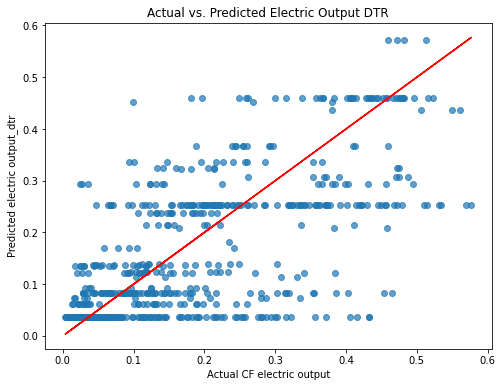

In [66]:
# Assuming the actual output (y_test) and predicted output (dtr_yp_test) of Decision Tree Regressor
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, dtr_yp_test, alpha=0.7)  # alpha controls the transparency of points

# Add labels and title
plt.xlabel('Actual CF electric output')
plt.ylabel('Predicted electric output_dtr')
plt.title('Actual vs. Predicted Electric Output DTR')

# Plot the line of perfect predictions
plt.plot(y_test, y_test, color='red')

# Show the plot
plt.show()

### 3.4 Setting up XGBoost Regressor
##### Defualt XGBoost Regressor

In [67]:
# XGB model without tuning the hyperparameters
def train_evaluate_xgboost(data, random_state=42):
    """
    Train and evaluate an XGBoost Regressor model with default parameters.

    Param:
         data : The DataFrame containing the data.
    
         random_state (int, optional): Random state for reproducibility. 

    Returns:
           float: MAE on the training set.
           float: MAE on the test set.
    """
     
    # Split data into train and test sets
    train, test, X_train, y_train, X_test, y_test = datetime_train_test_split(data)

    # Create an XGBoost Regressor model
    xgb_regressor = xgb.XGBRegressor(random_state=random_state)

    # Train the model
    xgb_regressor.fit(X_train, y_train)

    # Predict on training and test sets
    y_train_pred = xgb_regressor.predict(X_train)
    y_test_pred = xgb_regressor.predict(X_test)

    # Calculate MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    return mae_train, mae_test, y_train_pred, y_test_pred, xgb_regressor

In [68]:
# Evaluate the developed fuction 
mae_train, mae_test, y_train_pred, y_test_pred, xgb_regressor =train_evaluate_xgboost(df1)   

In [69]:
print(f" MAE on Training Set: {mae_train}")
print(f" MAE on Test Set: {mae_test}")
print("Hyperparameters:", best_params)

 MAE on Training Set: 0.003893808642890716
 MAE on Test Set: 0.06077044584545135
Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 6}


Note:
- This might indicate that the model is overfitting, it is generalized on the train data set as compared with test data set did.

##### Feature Importance

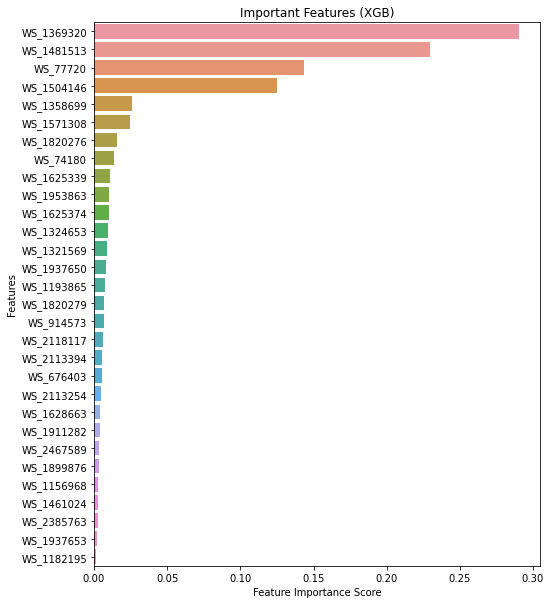

In [70]:
colss= X_train.columns
colx= [colss[x] for x in range(len(colss))]
feature_imp = pd.Series(xgb_regressor.feature_importances_,index=colx).sort_values(ascending=False)
plt.figure(figsize=(8,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features (XGB)");

In [71]:
res_XGB = pd.DataFrame({'CF':y_train, 'Predicted Values_XGB':pd.Series(y_train_pred)})
res_XGB.head()

,CF,Predicted Values_XGB
0,0.652524,0.652103
1,0.605852,0.610103
2,0.564094,0.560305
3,0.532721,0.532513
4,0.495608,0.497254


####  XGBoost : Applying Rigorous Grid Search to find the best XGB model parameters

In [72]:
param_grid_xgb = {'max_depth':[4, 5, 6],     # Depth of the tree
                 'n_estimators': [100, 200, 300], # Number of trees
                 'learning_rate': [0.05, 0.1, 0.2], 
                 'gamma':[0.05,0.1,0.15]} # For relatively small size of the data set, 
                                          # lower values of regularizers are more suitable.

In [73]:
res_xgb = {
    'max_depth': [],
    'n_estimators': [],
    'learning_rate': [],
    'gamma': [],
    'mae_train': [],
    'mae_test': []
}

step = 0
for m in param_grid_xgb['max_depth']:
    for n in param_grid_xgb['n_estimators']:
        for f in param_grid_xgb['learning_rate']:
            for l in param_grid_xgb['gamma']:
                step += 1
                print('Model {} of {}'.format(step, len(param_grid_xgb['max_depth']) *
                                               len(param_grid_xgb['n_estimators']) *
                                               len(param_grid_xgb['learning_rate']) *
                                               len(param_grid_xgb['gamma'])))
                
                model = xgb.XGBRegressor(max_depth=m,
                                         n_estimators=n,
                                         learning_rate=f,
                                         gamma=l,
                                         objective='reg:squarederror',
                                         reg_alpha=0.5,
                                         reg_lambda=2,
                                         random_state=42)
                
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                
                mae_train = mean_absolute_error(y_train, y_pred_train)
                mae_test = mean_absolute_error(y_test, y_pred_test)
                
                # This condition restrict the difference of test with train be positive to select the best hyperparameter
                if mae_test > mae_train:
                    res_xgb['max_depth'].append(m)
                    res_xgb['n_estimators'].append(n)
                    res_xgb['learning_rate'].append(f)
                    res_xgb['gamma'].append(l)
                    res_xgb['mae_train'].append(mae_train)
                    res_xgb['mae_test'].append(mae_test)

Model 1 of 81
Model 2 of 81
Model 3 of 81
Model 4 of 81
Model 5 of 81
Model 6 of 81
Model 7 of 81
Model 8 of 81
Model 9 of 81
Model 10 of 81
Model 11 of 81
Model 12 of 81
Model 13 of 81
Model 14 of 81
Model 15 of 81
Model 16 of 81
Model 17 of 81
Model 18 of 81
Model 19 of 81
Model 20 of 81
Model 21 of 81
Model 22 of 81
Model 23 of 81
Model 24 of 81
Model 25 of 81
Model 26 of 81
Model 27 of 81
Model 28 of 81
Model 29 of 81
Model 30 of 81
Model 31 of 81
Model 32 of 81
Model 33 of 81
Model 34 of 81
Model 35 of 81
Model 36 of 81
Model 37 of 81
Model 38 of 81
Model 39 of 81
Model 40 of 81
Model 41 of 81
Model 42 of 81
Model 43 of 81
Model 44 of 81
Model 45 of 81
Model 46 of 81
Model 47 of 81
Model 48 of 81
Model 49 of 81
Model 50 of 81
Model 51 of 81
Model 52 of 81
Model 53 of 81
Model 54 of 81
Model 55 of 81
Model 56 of 81
Model 57 of 81
Model 58 of 81
Model 59 of 81
Model 60 of 81
Model 61 of 81
Model 62 of 81
Model 63 of 81
Model 64 of 81
Model 65 of 81
Model 66 of 81
Model 67 of 81
Mode

In [74]:
# Optimized hyperparameters of the XGB model for the best model
pd.set_option('display.max_rows',5000)
res_df_xgb = pd.DataFrame.from_dict(res_xgb)
res_df_xgb.head()

,max_depth,n_estimators,learning_rate,gamma,mae_train,mae_test
0,4,100,0.05,0.05,0.035036,0.061593
1,4,100,0.05,0.10,0.038703,0.061898
2,4,100,0.05,0.15,0.041558,0.062714
3,4,100,0.10,0.05,0.033602,0.060919
4,4,100,0.10,0.10,0.038441,0.062282


In [75]:
# Sorted the Optimized hyperparameters
res_df_xgb2 = res_df_xgb.sort_values(['mae_test','mae_train'], ascending=False).reset_index(drop=True)
res_df_xgb2.head()

,max_depth,n_estimators,learning_rate,gamma,mae_train,mae_test
0,6,100,0.2,0.15,0.040059,0.065180
1,6,200,0.2,0.15,0.040059,0.065180
2,6,300,0.2,0.15,0.040059,0.065180
3,6,100,0.2,0.10,0.037561,0.064647
4,6,200,0.2,0.10,0.037561,0.064647


In [76]:
# Estimate the difference of mae on train and test data to select lower error
res_df_xgb['mae_diff'] = res_df_xgb['mae_test'] - res_df_xgb['mae_train']
res_df_xgb.head()

,max_depth,n_estimators,learning_rate,gamma,mae_train,mae_test,mae_diff
0,4,100,0.05,0.05,0.035036,0.061593,0.026557
1,4,100,0.05,0.10,0.038703,0.061898,0.023195
2,4,100,0.05,0.15,0.041558,0.062714,0.021157
3,4,100,0.10,0.05,0.033602,0.060919,0.027317
4,4,100,0.10,0.10,0.038441,0.062282,0.023841


In [77]:
# Sort the hyperparameters with errors difference
res_df_xgb3=res_df_xgb.sort_values(['mae_diff', 'mae_test', 'mae_train'], ascending=[True, False, False]).reset_index(drop=True)
res_df_xgb3.head()

,max_depth,n_estimators,learning_rate,gamma,mae_train,mae_test,mae_diff
0,4,100,0.20,0.15,0.041183,0.061485,0.020303
1,4,200,0.20,0.15,0.041183,0.061485,0.020303
2,4,300,0.20,0.15,0.041183,0.061485,0.020303
3,5,100,0.05,0.15,0.041319,0.061629,0.020310
4,5,200,0.05,0.15,0.040957,0.061287,0.020330


Note:
- To mitigate model complexity and potential overfitting, a lower difference value for the mean absolute error (mae_diff) was employed, along with a limited number of trees and a regularization strategy. Under these conditions, the hyperparameter values (max_depth = 4, n_estimators = 300, learning_rate = 0.2, gamma = 0.15) were identified as optimal at index 3. Due to the smaller size of the data set, a higher tree hyperparameter was chosen to enhance the model's ability to capture patterns within the data set.  These hyperparameters are intended for further predictions of the electric output from unseen data, which corresponds to wind speeds at different locations. Through the optimization process, a total of 81 models were generated, each with refined hyperparameters. By leveraging subject matter expertise and business insights, it's possible to select the best-performing model that aligns with the specific requirements and objectives of the analysis.

####  Making prediction by Best Hyperparameters

In [78]:
model_best_xgb = xgb.XGBRegressor(max_depth=4, 
                                  n_estimators=300,
                                  learning_rate=0.2,
                                  gamma=0.15,
                                  objective='reg:squarederror',
                                  reg_alpha=0.5,
                                  reg_lambda=1,
                                  random_state=42,
                                  verbosity = 0)

In [79]:
model_best_xgb.fit(X_train, y_train)

# Train and test prediction with optimized hyperparameters
xgb_yp_train = model_best_xgb.predict(X_train)
xgb_yp_test = model_best_xgb.predict(X_test)

# Estimate the errors
mae_train_best = mean_absolute_error(y_train, xgb_yp_train)
mae_test_best = mean_absolute_error(y_test, xgb_yp_test)

print(f"Best XGB MAE on Training Set: {round(mae_train_best, 4)}")
print(f"\nBest XGB MAE on Test Set: {round(mae_test_best, 4)}")

Best XGB MAE on Training Set: 0.0409

Best XGB MAE on Test Set: 0.0645


Note:
- This indicate the give data set perform well in these optimized hyperparameters of XGBRegressor

In [80]:
res_XGB = pd.DataFrame({'CF':y_train, 'Predicted_Train_XGB_Best':pd.Series(xgb_yp_train)})
res_XGB.head()

,CF,Predicted_Train_XGB_Best
0,0.652524,0.572323
1,0.605852,0.561467
2,0.564094,0.530113
3,0.532721,0.521475
4,0.495608,0.481710


In [81]:
res_XGB_test = pd.DataFrame({'CF':y_test, 'Predicted_Test_XGB_Best':(xgb_yp_test)}).reset_index(drop= True)
res_XGB_test.head()

,CF,Predicted_Test_XGB_Best
0,0.219679,0.253891
1,0.200425,0.253891
2,0.181658,0.253891
3,0.138335,0.284383
4,0.103646,0.263251


#### Actual values versus Predicted values of test

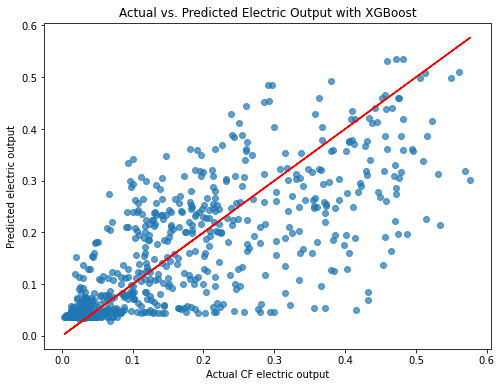

In [82]:
# Assuming the actual output (y_test) and predicted output (xgb_yp_test) from XGBoost model
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_yp_test, alpha=0.7)  # alpha controls the transparency of points

# Add labels and title
plt.xlabel('Actual CF electric output')
plt.ylabel('Predicted electric output')
plt.title('Actual vs. Predicted Electric Output with XGBoost')

# Plot the line of perfect predictions
plt.plot(y_test, y_test, color='red')

# Show the plot
plt.show()


### 3.5 Model Explainability using SHAP
#####  XGBoost Best Selected Model

In [83]:
# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(model_best_xgb)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


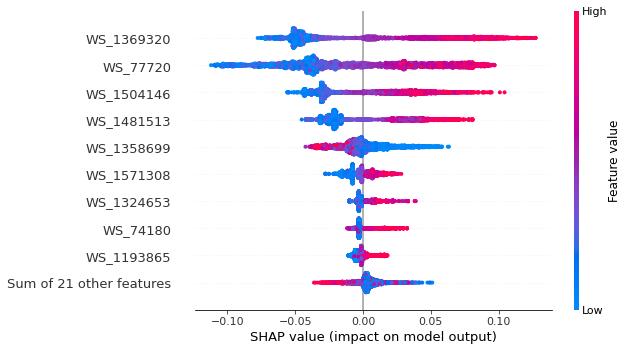

In [84]:
shap.plots.beeswarm(shap_values, max_display=10)

In the above plot blue to red color indicates predictability capacbility of the features from lower to higher. The plot suggests that the top features have better contiribution towards positive elctric output prediction as compared the lower values. Foreinstance, wind speed (WS_1369320) shows more increasing the speed have influnce on a higher electric output as compared with the blue colored lower values.

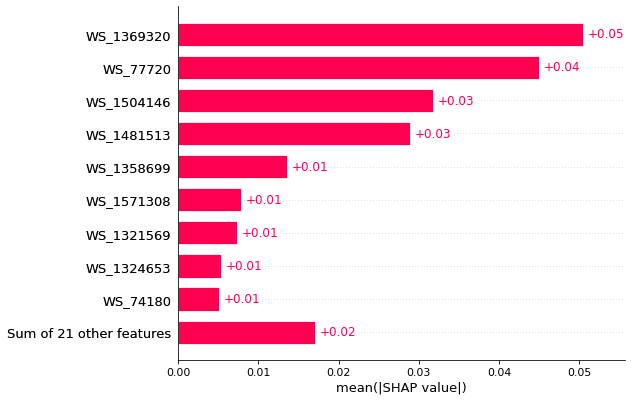

In [85]:
shap.plots.bar(shap_values, max_display=10)

In the above plot, one can see that the top 10 SHAP importance features are shown in the XGB important features graph. This indicated the top list features have influenced the predictabilities of the model.

### 3.6 Deep Learning Model
#####  Tensorflow
###### Scaling the data set

In [86]:
# Initialize the Scaler
scaler = MinMaxScaler()

In [87]:
# Fit the scaler on the training data and transform both training and test data
X_train_sc= scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [88]:
X_train_sc.shape

(2908, 30)

In [89]:
X_test_sc.shape

(727, 30)

#### Creating a Model

In [90]:
# Create a Sequential model
model_tf = Sequential()

# Add a Dense layer with 256 units and ReLU activation
model_tf.add(Dense(256, activation='relu'))

# Add a Dropout layer with dropout rate of 0.25
model_tf.add(Dropout(0.25))

# Add another Dense layer with 128 units and ReLU activation
model_tf.add(Dense(128, activation='relu'))

# Add another Dropout layer with dropout rate of 0.25
model_tf.add(Dropout(0.25))

# Add another Dense layer with 64 units and ReLU activation
model_tf.add(Dense(64, activation='relu'))

# Add another Dropout layer with dropout rate of 0.25
model_tf.add(Dropout(0.25))

# Add another Dense layer with 32 units and ReLU activation
model_tf.add(Dense(32, activation='relu'))

# Add a final Dense layer with 1 unit (output layer)
model_tf.add(Dense(1))

# Compile the model using Adam optimizer and mean absolute error (MAE) loss
model_tf.compile(optimizer='adam', loss='mae')

#### Adding Earlystopping

In [91]:
# EarlyStopping is used to stop training when a monitored metric has stopped improving
# In this case, it monitors 'val_loss' (validation loss) and stops training if it doesn't improve for 'patience' epochs
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [92]:
model_tf.fit(x=X_train_sc, y=y_train.values, batch_size=32, epochs=600, validation_data=(X_test_sc, y_test.values), verbose=1, callbacks=[early_stop])

Epoch 1/600
91/91 [==============================] - 0s 3ms/step - loss: 0.0969 - val_loss: 0.0877
Epoch 2/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0676
Epoch 3/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0626
Epoch 4/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0726
Epoch 5/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0731
Epoch 6/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0550 - val_loss: 0.0583
Epoch 7/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0541 - val_loss: 0.0567
Epoch 8/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0529 - val_loss: 0.0578
Epoch 9/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0591
Epoch 10/600
91/91 [==============================] - 0s 1ms/step - loss: 0.0499 - val_loss: 0.0588
Epoch 000

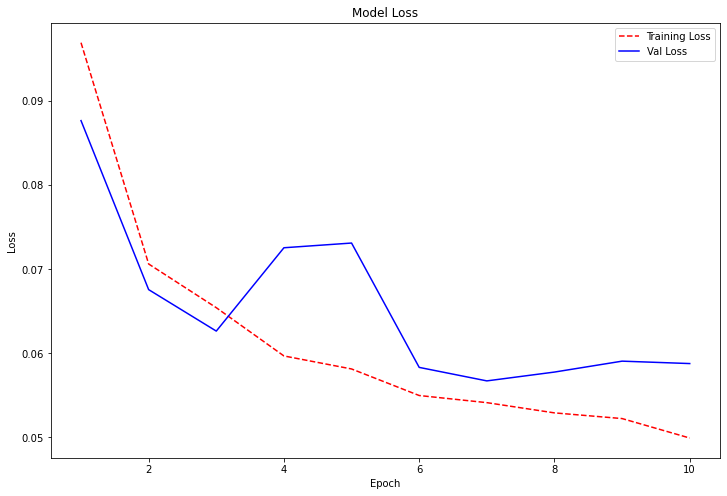

In [93]:
model_loss = pd.DataFrame(model_tf.history.history)
epocx = range(1, len( model_loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epocx, model_loss['loss'], 'r--', epocx, model_loss['val_loss'],'b-'); 
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss');

#### Training the Model

In [94]:
model_tf.fit(x=X_train_sc,y=y_train.values,
          validation_data=(X_test_sc,y_test.values),
          batch_size=16,epochs=3)

Epoch 1/3
182/182 [==============================] - 0s 1ms/step - loss: 0.0532 - val_loss: 0.0645
Epoch 2/3
182/182 [==============================] - 0s 1ms/step - loss: 0.0502 - val_loss: 0.0530
Epoch 3/3
182/182 [==============================] - 0s 1ms/step - loss: 0.0498 - val_loss: 0.0556


#### Evaluation on Test Data

#### Predicting on test data set

In [95]:
tf_yp_test = model_tf.predict(X_test_sc)

In [96]:
# Evaluate the model
mae = mean_absolute_error(y_test, tf_yp_test)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.055600696932947724


In [97]:
tf_yp_train = model_tf.predict(X_train_sc)

# Evaluate the model
mae = mean_absolute_error(y_train, tf_yp_train)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.04265584254565343


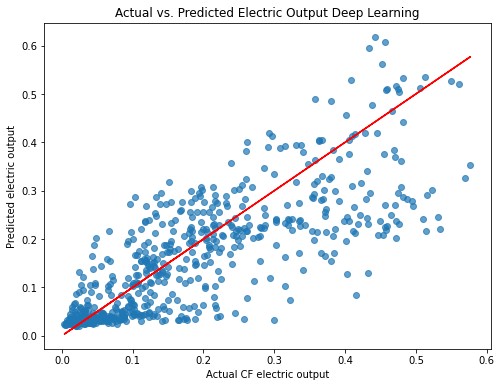

In [98]:
# Assuming the actual output (y_test) and predicted output (tf_yp_test) from Deep Learning model
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, tf_yp_test, alpha=0.7)  # alpha controls the transparency of points

# Add labels and title
plt.xlabel('Actual CF electric output')
plt.ylabel('Predicted electric output')
plt.title('Actual vs. Predicted Electric Output Deep Learning')

# Plot the line of perfect predictions
plt.plot(y_test, y_test, color='red')

# Show the plot
plt.show()


## 4 Comparison of Baseline Model vs Improved Models

In [99]:
# Calculate Mean Absolute Error (MAE) for the Baseline model on training and test sets
train_base =  mean_absolute_error(y_train, Baseline['Baseline'])
test_base =  mean_absolute_error(y_test, Baseline_test['Baseline_test'])

# Calculate Mean Squared Error (MSE) for the Decision Tree Regressor (DTR) model on training and test sets
train_dtr =  mean_absolute_error(y_train, dtr_yp_train)
test_dtr =  mean_absolute_error(y_test, dtr_yp_test)

# Calculate Mean Absolute Error (MAE) for the XGBoost (XGB) model on training and test sets
train_xgb =  mean_absolute_error(y_train, xgb_yp_train)
test_xgb =  mean_absolute_error(y_test, xgb_yp_test)

# Calculate Mean Absolute Error (MAE) for the TensorFlow (TF) model on training and test sets
train_tf =  mean_absolute_error(y_train, model_tf.predict(X_train_sc))
test_tf =  mean_absolute_error(y_test,tf_yp_test)

In [100]:
# # Create an empty DataFrame to store model evaluation results
# # The DataFrame will have columns 'Model', 'MAE_train', and 'MAE_test'
# res_all = pd.DataFrame({'Model': [], 'MAE_train': [], 'MAE_test': []})


In [101]:
# Create an empty DataFrame to store model evaluation results
# The DataFrame will have columns 'Model', 'MAE_train', and 'MAE_test'
res_all = pd.DataFrame({'Model':[], 'MAE_train':[], 'MAE_test':[]})

In [102]:
# Create a DataFrame to store the results of different models
res_all['Model'] = ['Baseline Model', 'Decision Tree', 'XGBoost', 'TensorFlow (Deep Leaning)']

# Add columns for MAE on the training and test sets
res_all['MAE_train'] = [train_base, train_dtr, train_xgb, train_tf]
res_all['MAE_test'] = [test_base, test_dtr, test_xgb, test_tf]

# Display the DataFrame containing model names and their respective MAE values
res_all

,Model,MAE_train,MAE_test
0,Baseline Model,0.143256,0.127520
1,Decision Tree,0.048738,0.071136
2,XGBoost,0.040881,0.064545
3,TensorFlow (Deep Leaning),0.042656,0.055601


The above table shows that all regressor models perform much better than the baseline model. Deep Learning  and XGBoost seems to perform better in the training and test data set with lowest mae differnce between the two data sets. Deep Learning shows best performance in both training and test data sets. <br> 

If I had time, I would have conducted an extensive Grid Search to identify optimal performance parameters for all models. I am confident that by leveraging their respective best parameters, the models would exhibit significantly enhanced performance compared to the results presented above. <br> 

I employed a combination of recursive feature selection and correlation-based model features selection to achieve the reported performance values. Another strategy I explored involved developing models using 90% of non-correlated features, which effectively mitigated the impact of highly correlated features and enhanced overall model performance by excluding extraneous attributes. Additionally, I conducted a thorough correlation analysis to identify and eliminate features that exhibited strong correlations with one another.

## 5 Forecast Electric Output(CF_pred) using unseen Data Set
Use best performing Deep Learning to generate the prediction with a give predict data set. First the data set need to be sorted with the features names of the developed models. Then, use the developed functions to clean and further analysis prior to make the prediction. Finally, the predicted values generated by the Deep Learning model are stored in the same directory as the data set with CSV file format.

In [103]:
# Out of sample data set in dataframe
df_predict.head()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
0,2020-01-09 00:00:00,2019-08-07,1.69,1.88,3.15,0.92,2.27,1.14,1.24,2.98,...,1.40,1.27,1.27,1.43,1.28,1.91,1.12,1.15,1.35,1.46
1,2020-01-09 01:00:00,NaT,1.60,2.02,3.91,0.44,2.36,1.15,1.63,2.83,...,1.02,1.11,1.43,2.04,1.60,1.57,1.03,1.28,1.49,1.29
2,2020-01-09 02:00:00,NaT,1.79,2.14,4.20,0.65,2.06,1.28,2.36,3.07,...,1.39,1.42,1.42,2.91,1.81,1.85,1.10,1.56,1.54,1.56
3,2020-01-09 03:00:00,NaT,2.01,2.32,5.17,0.51,2.31,0.83,3.39,3.38,...,1.55,2.01,1.26,2.49,2.09,2.09,1.06,2.12,1.66,2.18
4,2020-01-09 04:00:00,NaT,2.12,2.54,4.19,0.77,4.52,0.97,2.89,3.79,...,1.64,2.40,1.69,1.36,2.08,2.06,1.08,2.33,2.17,2.60


In [104]:
# Sort the given data set with the features selected in the train data set used for model development
columns_list = df1.drop(['RID', 'CF'], axis=1).columns # df1 is the dataframe of train data set
columns_list

Index(['WS_1156968', 'WS_1182195', 'WS_1193865', 'WS_1321569', 'WS_1324653',
       'WS_1358699', 'WS_1369320', 'WS_1461024', 'WS_1481513', 'WS_1504146',
       'WS_1571308', 'WS_1625339', 'WS_1625374', 'WS_1628663', 'WS_1820276',
       'WS_1820279', 'WS_1899876', 'WS_1911282', 'WS_1937650', 'WS_1937653',
       'WS_1953863', 'WS_2113254', 'WS_2113394', 'WS_2118117', 'WS_2385763',
       'WS_2467589', 'WS_676403', 'WS_74180', 'WS_77720', 'WS_914573'],
      dtype='object')

In [105]:
# Predict (OUT of Sample) data set dataframe sorted by the train selected features
df_predict_model= df_predict[columns_list]
df_predict_model.head()

,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1369320,WS_1461024,WS_1481513,WS_1504146,...,WS_1953863,WS_2113254,WS_2113394,WS_2118117,WS_2385763,WS_2467589,WS_676403,WS_74180,WS_77720,WS_914573
0,3.15,0.92,2.27,1.14,1.24,2.98,1.55,1.59,1.10,2.09,...,10.07,2.50,3.04,3.20,9.10,1.60,1.28,1.54,1.35,1.12
1,3.91,0.44,2.36,1.15,1.63,2.83,1.17,1.66,1.28,2.43,...,9.97,1.72,4.72,4.62,8.29,3.25,1.22,1.68,1.13,1.03
2,4.20,0.65,2.06,1.28,2.36,3.07,1.55,1.82,1.29,3.49,...,9.79,1.37,5.27,5.17,7.65,3.64,1.31,1.64,1.43,1.10
3,5.17,0.51,2.31,0.83,3.39,3.38,1.73,1.72,1.04,2.77,...,9.72,1.52,5.47,4.98,6.99,3.59,1.50,1.78,1.81,1.06
4,4.19,0.77,4.52,0.97,2.89,3.79,1.58,2.23,1.08,1.83,...,9.26,1.13,6.49,5.18,5.59,4.49,1.52,2.01,2.17,1.08


In [106]:
# Record Identifier of the unseen data set
ID=df_predict['DATETIME']

In [107]:
# Concatenate the RID to the unseen data set
X_unseen= pd.concat([ID, df_predict_model], axis =1).reset_index(drop=True)

In [108]:
X_unseen.head()

,DATETIME,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1369320,WS_1461024,WS_1481513,...,WS_1953863,WS_2113254,WS_2113394,WS_2118117,WS_2385763,WS_2467589,WS_676403,WS_74180,WS_77720,WS_914573
0,2020-01-09 00:00:00,3.15,0.92,2.27,1.14,1.24,2.98,1.55,1.59,1.10,...,10.07,2.50,3.04,3.20,9.10,1.60,1.28,1.54,1.35,1.12
1,2020-01-09 01:00:00,3.91,0.44,2.36,1.15,1.63,2.83,1.17,1.66,1.28,...,9.97,1.72,4.72,4.62,8.29,3.25,1.22,1.68,1.13,1.03
2,2020-01-09 02:00:00,4.20,0.65,2.06,1.28,2.36,3.07,1.55,1.82,1.29,...,9.79,1.37,5.27,5.17,7.65,3.64,1.31,1.64,1.43,1.10
3,2020-01-09 03:00:00,5.17,0.51,2.31,0.83,3.39,3.38,1.73,1.72,1.04,...,9.72,1.52,5.47,4.98,6.99,3.59,1.50,1.78,1.81,1.06
4,2020-01-09 04:00:00,4.19,0.77,4.52,0.97,2.89,3.79,1.58,2.23,1.08,...,9.26,1.13,6.49,5.18,5.59,4.49,1.52,2.01,2.17,1.08


In [109]:
# Cleaning of out of sample data prior to prediction
X_unseen = excluding_duplicate_features_and_get_distinic_record_id(X_unseen)
X_unseen.head()

,RID,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1369320,WS_1461024,WS_1481513,...,WS_1953863,WS_2113254,WS_2113394,WS_2118117,WS_2385763,WS_2467589,WS_676403,WS_74180,WS_77720,WS_914573
0,2020-01-09 00:00:00,3.15,0.92,2.27,1.14,1.24,2.98,1.55,1.59,1.10,...,10.07,2.50,3.04,3.20,9.10,1.60,1.28,1.54,1.35,1.12
1,2020-01-09 01:00:00,3.91,0.44,2.36,1.15,1.63,2.83,1.17,1.66,1.28,...,9.97,1.72,4.72,4.62,8.29,3.25,1.22,1.68,1.13,1.03
2,2020-01-09 02:00:00,4.20,0.65,2.06,1.28,2.36,3.07,1.55,1.82,1.29,...,9.79,1.37,5.27,5.17,7.65,3.64,1.31,1.64,1.43,1.10
3,2020-01-09 03:00:00,5.17,0.51,2.31,0.83,3.39,3.38,1.73,1.72,1.04,...,9.72,1.52,5.47,4.98,6.99,3.59,1.50,1.78,1.81,1.06
4,2020-01-09 04:00:00,4.19,0.77,4.52,0.97,2.89,3.79,1.58,2.23,1.08,...,9.26,1.13,6.49,5.18,5.59,4.49,1.52,2.01,2.17,1.08


In [110]:
# Unseen data set for prediction using cleaned X_unseen data set
# DL model used as the selected as champion model to make prediction
y_pred_unseen = pd.DataFrame(model_tf.predict(X_unseen.drop(['RID'], axis =1)), columns =['Predicted_CF'])

In [111]:
# Merge the predicted value with record identifier (RID) of unseen data set (given predict data)
y_unseen_pred_df= pd.concat([ID, y_pred_unseen], axis =1).reset_index(drop = True)

In [112]:
y_unseen_pred_df.head()

,DATETIME,Predicted_CF
0,2020-01-09 00:00:00,0.886243
1,2020-01-09 01:00:00,0.870035
2,2020-01-09 02:00:00,1.031821
3,2020-01-09 03:00:00,1.331951
4,2020-01-09 04:00:00,1.227764


##### Save predicted electric output

In [113]:
#Saving the pridected values for submition
y_unseen_pred_df.to_csv('predicted_electric_output_CF.csv', index=False) 

## 6 Summary

In this exercise, I tried to establish a Baseline model and improved models to predict electric output with local wind speeds in different locations. The Baseline model was established using historical electric output from the training data set. Improved models were built using Decision Tree, XGBoost, and Deep Learning (Tensorflow). 

The result shows that improved models perform much better than the baseline model especially Deep Learning seems to perform better on the training data set as well as test data set without overfitting as compared to the other models. The  XGBoost shows reasonable performance in both training and test data sets. 

Performing rigorous Hyperparameter tuning to get the best performance parameters for all models and use them to train the models will significantly improve model performance. The next section will describe in detail my future improvement thoughts to improve model performance.

## 7 Further Improvement Thoughts

Here is my thoughts how I could improve the model performance if I had enough: <br>

* Get better understanding of the data <br>
    - This approach addresses feature cleaning by covering strategies for handling duplicated records, mitigating data leakage issues, exploring diverse correlation levels, and experimenting with the combination and transformation of various features to effectively reduce dimensionality.<br>
    
* Hyperparameter Tuning <br> 
     - Conducting a thorough Grid Search process to identify optimal performance parameters for all models. Utilizing these individually tailored best parameters is expected to enhance the overall performance of the models.. 
     
* Model Based Feature Selection and dimension reduction <br>
  - Using all available features doesn't inherently enhance model performance, as certain features might not contribute significantly as predictors. Therefore, opting to choose a subset of the top n (for example, 30) features that exhibit strong predictive capabilities for the target variable is a prudent approach. By training the model with these selected features, it becomes possible to assess its performance accurately. <br>
  
* Correlation Analysis: <br>
  - Conducting a correlation analysis aids in the identification of highly correlated features. In cases where two features exhibit strong correlation, it's recommended to remove one of them. <br>
  
* Standardize/Normalizing the features and targets <br>
  - Generally, standardizing or normalizing data aids in quicker model convergence and leads to improved overall model performance. Experimenting with this approach is recommended to gauge its impact on model performance. For Deep Learning, standardizing the features is common practice; however, it's also worth exploring its effects on Decision Tree and XGBoost models to understand how they respond

* Handling outliers <br>
   - Check the presence of outliers both in the features and target variables. If there are outliers (say outsides mean +/- 3*std or median +/- 1.5*IQR), it is a good idea to exclude these outliers from the model training and see how the model performs. 

# END
# 2023-08-22 @ 1:30 PM CDT